In [1]:
# Valid for non-precessing systems since we assume the symmetry hm=((-1)**l)*(np.conj(h))!
from platform import python_version
print(python_version())

3.7.3


In [2]:
import Functions as fun
import argparse
from configparser import ConfigParser
import corner
import os
import pandas as pd
import glob
import json
import numpy as np
from pycbc import psd
import h5py
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import dynesty
from dynesty import plotting as dyplot
from pycbc.waveform import td_approximants
import pycbc.psd

In [3]:
# Cell that calls the arguments from your 'config.ini' file. 
try:
    parser = argparse.ArgumentParser(description="Simple argument parser")
    parser.add_argument("-c", action="store", dest="config_file")
    result = parser.parse_args()
    config_file=result.config_file
    parser = ConfigParser()
    parser.read(config_file)
    parser.sections()
except SystemExit: 
    parser = ConfigParser()
    parser.read('config_TSEOBNRE.ini')
    parser.sections()
    pass

usage: ipykernel_launcher.py [-h] [-c CONFIG_FILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /work/yifan.wang/.local/share/jupyter/runtime/kernel-b0426fa1-481e-48d7-9635-e807b71957d4.json


In [4]:
sxs_root_folder="/work/francisco.jimenez/SXS/data/"

In [5]:
#eccentric_file_index

In [6]:
# Define the path to the nr files
model=parser.get('setup','model')
export_bool=eval(parser.get('setup','export'))
eccentric_index=int(parser.get('setup','index'))
eccentric_file_index=int(parser.get('setup','file_index'))
export_folder_root = parser.get('setup','export_folder_root')
nlive = int(parser.get('setup','nlive'))
#eccentric_index=9

eccentric_cases = pd.read_csv (r'SXS_eccentric_'+str(eccentric_file_index)+'.csv')
eccentric_cases_list = eccentric_cases['SXS_eccentric'][:]

NoSectionError: No section: 'setup'

In [7]:
# Find the SXS metadata and strain files 
eccentric_case = sxs_root_folder+eccentric_cases_list[eccentric_index]
sxs_file = glob.glob(eccentric_case+'/**/rhOverM_Asymptotic_GeometricUnits_CoM.h5',recursive=True)
sxs_file.sort(reverse=True)
sxs_file = sxs_file[0]

json_metafiles = (glob.glob(eccentric_case+"/**/metadata.json", recursive = True))
json_metafiles.sort(reverse=True)
json_metafiles = json_metafiles[0]

print("SXS strain file: ", sxs_file)
print("SXS metadata file: ", json_metafiles)

NameError: name 'eccentric_cases_list' is not defined

In [8]:
sxs_file = '/work/francisco.jimenez/SXS/data/SXS_BBH_1358/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5'
json_metafiles = '/work/francisco.jimenez/SXS/data/SXS_BBH_1358/Lev3/metadata.json'

In [9]:
export_folder=export_folder_root+'NR_'+model+'/'+eccentric_cases_list[eccentric_index]
if not os.path.exists(export_folder):
    os.makedirs(export_folder)
    print("Directory " , export_folder ,  " Created ")

NameError: name 'export_folder_root' is not defined

In [10]:
# Load SXS metadata
metadata = {}
for i in range(len(json_metafiles)):
    with open(json_metafiles) as file:
        metadata = json.load(file)
        
mass = 100
mass1 = mass*metadata['reference_mass1']
mass2 = mass*metadata['reference_mass2']
massratio = max(mass1/mass2,1)
spin1 = metadata['reference_dimensionless_spin1'][-1]
spin2 = metadata['reference_dimensionless_spin2'][-1]
omega_0 =2*metadata["initial_orbital_frequency"]
T_0= 2*np.pi/omega_0
f_0 = omega_0/(2*np.pi)

max(20,fun.f_to_Phys(f_0,10))

89.54957937000034

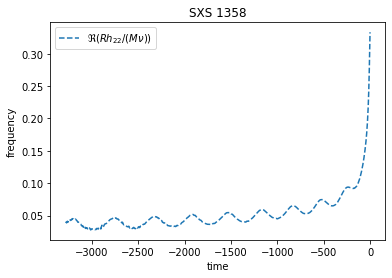

In [11]:
# Load SXS data
gw = h5py.File(sxs_file, 'r') 

gw_sxs_bbh = gw["Extrapolated_N3.dir"]["Y_l2_m2.dat"] 
times = gw_sxs_bbh[:,0]
dt=fun.time_to_t_NR(1/1024.,mass)
sxs_wave=gw_sxs_bbh[:,1]-1j*gw_sxs_bbh[:,2]
tmrg = times[np.argmax(np.abs(sxs_wave))]
times = times - tmrg

sxs_wave_int=interp1d(times, sxs_wave, kind='cubic')
times= np.arange(times[0], times[-1], dt)
sxs_wave = sxs_wave_int(times)
sxs_wave = sxs_wave[np.argmax(times >= (times[0]+200)):np.argmax(times >= (-0))]
times = times[np.argmax(times >= (times[0]+200)):np.argmax(times >= (-0))]


sxsphas = np.angle(sxs_wave)
sxsphas = np.unwrap(sxsphas)
sxsfreq = np.gradient(sxsphas, times)
sxsfreq_int = interp1d(times,sxsfreq,kind='cubic')
plt.plot(times, sxsfreq, '--', label=r'$\Re{(Rh_{22}/(M\nu))}$')
#plt.title(eccentric_cases_list[eccentric_index])
plt.title('SXS 1358')
plt.xlabel('time')
plt.ylabel('frequency')
plt.legend()

In [12]:
# Find the true anomaly, reference eccentricity and other parameters from metadata
di=metadata['initial_separation']
ecc_nr=metadata['reference_eccentricity']
#mean_anomaly=metadata['reference_mean_anomaly']
#true_anomaly=mean_anomaly+(2*ecc_nr-ecc_nr**3/4)*np.sin(mean_anomaly)+5/4*ecc_nr**2*np.sin(2*mean_anomaly)+13/12*ecc_nr**3*np.sin(3*mean_anomaly)
#perihelion=di*(1+ecc_nr*np.cos(true_anomaly))/(1-ecc_nr**2)
#(perihelion**2)*metadata['initial_adot']
ecc_nr

0.2186272

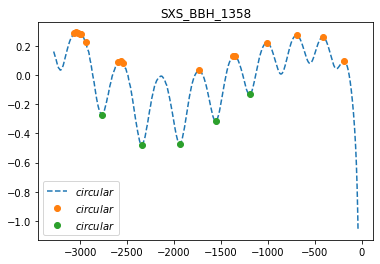

In [15]:
# Find eccentricity from orbital frequency
bool_fact=times<=times[0]+300+16*T_0
times_fit=times[bool_fact]
sxsfreq_fit=sxsfreq[bool_fact]
freqcfit=np.polyfit(times_fit, sxsfreq_fit, 2)
sxsfreq_fitc = np.poly1d(freqcfit)
sxsfreq_ecc_estimate=1-sxsfreq_fit/sxsfreq_fitc(times_fit)
sxsfreq_ecc_estimate=fun.moving_average(sxsfreq_ecc_estimate, 20)
times_fit = times_fit[:-19]
peaks_pos=find_peaks(sxsfreq_ecc_estimate, height=0)
peaks_neg=find_peaks(-sxsfreq_ecc_estimate, height=-0)
plt.plot(times_fit, sxsfreq_ecc_estimate, '--', label=r'$circular$')
plt.plot(times_fit[peaks_pos[0]], peaks_pos[1]['peak_heights'], 'o', label=r'$circular$')
plt.plot(times_fit[peaks_neg[0]],-peaks_neg[1]['peak_heights'], 'o', label=r'$circular$')
#plt.title(eccentric_cases_list[eccentric_index])
plt.title('SXS_BBH_1358')
plt.legend()

In [16]:
# eccentricity estimate as in Eq. 2.8 odf 1909.11011
wp =omega_0*(1 + np.mean(peaks_pos[1]['peak_heights']))
wa =omega_0*(1 - np.mean(peaks_neg[1]['peak_heights']))
ecc_NR = (wp**0.5 - wa**0.5)/(wp**0.5 + wa**0.5)
ecc_NR

0.1445707521926217

In [19]:
print('massratio: ',massratio)
print('mass1: ',mass1)
print('mass2: ',mass2)
print('spin1: ',spin1)
print('spin2: ',spin2)
print('eccentricity: ', ecc_NR)

massratio:  1
mass1:  49.9997760273
mass2:  49.999784611100004
spin1:  -2.54835566879e-05
spin2:  -2.57800521003e-05
eccentricity:  0.1445707521926217


In [177]:
#Define min and max eccentricity for the priors
emin=0
distance = 100; inclination = 0; l=2; m=2; 
if ecc_NR<0.2:
    emax=0.41
else:
    emax=0.41

In [178]:
ecc_clas=fun.Eccentricity_PE([mass1,mass2,spin1,spin2,distance],
                              sxsfreq_int,model=model,times=times,sxsfreq=sxsfreq,
                              emin=emin,emax=emax,fmin=5,fmax=10)


In [71]:
import time
t1=time.time()
ecc_clas.model_SEOBNRE([0.4,20])
t2=time.time()
t2-t1

11.524622440338135

In [44]:
import time
t1=time.time()
ecc_clas.model_TSEOBNRE([0.4,20])
t2=time.time()
t2-t1

0.0848848819732666

In [82]:
from pycbc.pool import choose_pool
pool = choose_pool(8)
pool.size=8
nlive = 1000

In [83]:
f2=dynesty.NestedSampler(ecc_clas.log_likelihood,ecc_clas.prior_transform,
                         2,nlive=nlive,sample='rwalk',pool=pool)
f2.run_nested(print_progress=True,dlogz=0.1)
pool.close()

556it [01:36,  5.78it/s, +1000 | bound: 0 | nc: 1 | ncall: 1754 | eff(%): 88.712 | loglstar:   -inf < -0.008 <    inf | logz: -0.137 +/-    nan | dlogz:  0.001 >  1.009]


In [84]:
import importlib
importlib.reload(fun)
res = f2.results
res.samples_u.shape
res.summary()
samps=f2.results.samples
postsamps = fun.posterior_samples(f2)
bvals = postsamps[-1]

Summary
nlive: 1000
niter: 556
ncall: 1754
eff(%): 88.712
logz: -0.137 +/-    nan


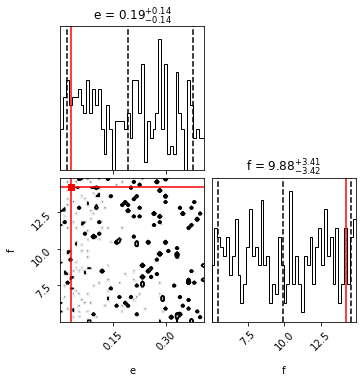

In [75]:
fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,truths=bvals,labels=['e','f'],truth_color='red')
plt.show()

In [223]:
f0eob=fun.f_to_Phys(0.02123/(2*np.pi),mass)
f0eob

6.861391481347664

In [232]:
ecc_clas=fun.Eccentricity_PE([mass1,mass2,spin1,spin2,distance],
                              sxsfreq_int,model=model,times=times,sxsfreq=sxsfreq,
                              emin=emin,emax=emax,fmin=5,fmax=10)

dict = {'SEOBNRE':ecc_clas.model_SEOBNRE,'TSEOBNRE':ecc_clas.model_TSEOBNRE}
times_seobe, h_seobnre_phys= dict[model]([0.18078,f0eob
                                        ],strain=True)
#times_seobe = fun.time_to_t_NR(times_seobe,mass)
#h_seobe_nr = fun.amp_to_nr(h_seobnre_phys,mass,distance,2,2,0)

from pycbc.types import TimeSeries
eob_wave = h_seobnre_phys
start_time=times_seobe[0]

wf = TimeSeries(eob_wave, delta_t=1/4096,epoch=start_time)    
hp, hc = wf.real(), wf.imag()

start_time=times[0]

wf = TimeSeries(sxs_wave, delta_t=1/4096,epoch=start_time)    
hpsxs, hcsxs = wf.real(), wf.imag()

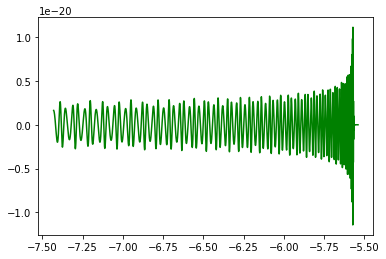

In [236]:
#plt.plot(hpsxs.sample_times, hpsxs, label='NR',color='g')
plt.plot(hp.sample_times, hp, label='eob',color='g')



In [215]:
# load metadata
#f_low = np.float(parser.get('setup','f_low'))
export_file=export_folder+'/model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_w0_'+str(np.around(bvals[1],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.csv'
mismatch_plot=export_folder+'/mm_model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.png'
wave_td_plot=export_folder+'/td_model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.png'
wave_fd_plot=export_folder+'/fd_model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.png'

In [216]:
if times_seobe[0]>=times[0]:
    times_seobe_v1 = times_seobe[:np.argmax(times_seobe >= (100))]
    h_seobe_nr = h_seobe_nr[:np.argmax(times_seobe >= (100))]
    sxs_wave = sxs_wave_int(times_seobe_v1)
    times = times_seobe_v1
else:
    times = np.arange(times[0], 100, dt)
    sxs_wave = sxs_wave_int(times)
    
    eob_int=interp1d(times_seobe, h_seobe_nr, kind='cubic')
    h_seobe_nr=eob_int(times)

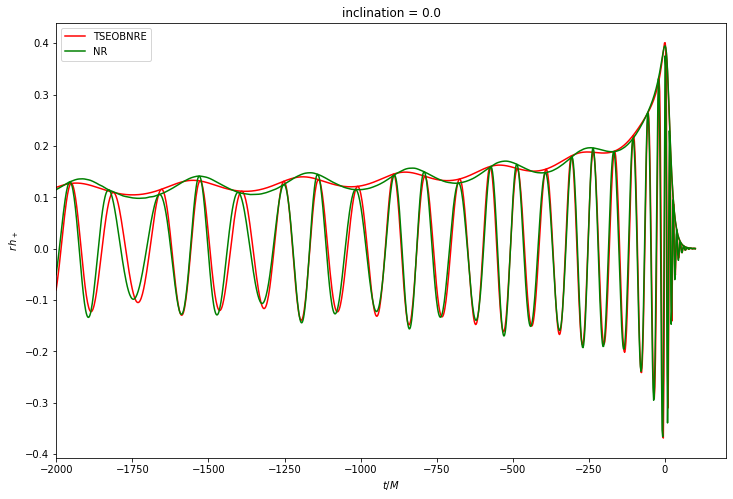

In [217]:
# plot the nr data in phys. units
figband = plt.figure(figsize = (12, 8))
plt.plot(times, h_seobe_nr.real, label=model,color='r')
plt.plot(times, np.sqrt(h_seobe_nr.real**2+h_seobe_nr.imag**2),color='r',label=None)

plt.plot(times, sxs_wave.real, label='NR',color='g')
plt.plot(times, np.sqrt(sxs_wave.real**2+sxs_wave.imag**2),color='g',label=None)


plt.xlabel(r'$t/M$')
plt.ylabel(r'$r \, h_+$')
plt.xlim(-2000,200)
plt.title(r'inclination = '+str(inclination/np.pi))
plt.legend(loc='upper left')
if export_bool:
    figband.savefig(wave_td_plot)

/work/francisco.jimenez/myvenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/work/francisco.jimenez/myvenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


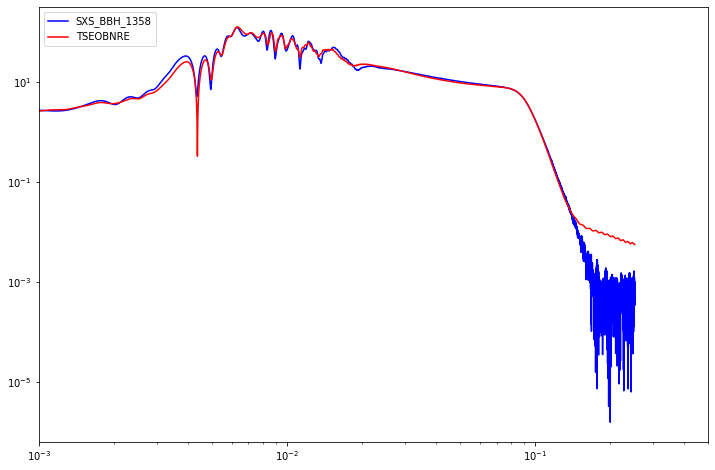

In [186]:
h_px=np.array([times,sxs_wave]).T 
h_eob=np.array([times,h_seobe_nr]).T 
tlow_nr = h_eob[0,0]+ 150
thigh_nr = 150
sigmalo = 100

tlow_eob = h_eob[0,0]+ 150
thigh_eob = 150

px_fft=fun.FFT_ZeroPadded_Windowed( h_px, nleft=100000,nright=1000000,x_low=tlow_nr, sigma_low=sigmalo,x_high=thigh_nr,sigma_high=sigmalo)
eob_fft=fun.FFT_ZeroPadded_Windowed(h_eob,nleft=100000,nright=1000000,x_low=tlow_eob,sigma_low=sigmalo,x_high=thigh_eob,sigma_high=sigmalo)
flow = 8
delta_f = 1.0 /16
flen = int(2048 / delta_f) + 1
frange=np.arange(flow,flow+delta_f*flen,delta_f)
psd_noise = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_int=interp1d(frange, psd_noise, kind='cubic')

figband = plt.figure(figsize = (12, 8))
plt.plot(px_fft[:,0], np.abs(px_fft[:,1]),'b',label=eccentric_cases_list[eccentric_index])
plt.plot(eob_fft[:,0], np.abs(eob_fft[:,1]),'r',label=model)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlim(0.001,0.5)
if export_bool:
    figband.savefig(wave_fd_plot)

In [222]:
fun.f_to_Phys(0.02,mass)

40.61365439699559

100

In [196]:
1-fun.EasyMatch(px_fft,eob_fft,psd_int,30,1000,nright=30000,f_units='Mf',mass=70)
fun.EasyMatch(px_fft,eob_fft,psd_int,30,1000,nright=30000,f_units='Mf',mass=70)

0.974043820193658

In [197]:
mmatch=[None]*198
for m in range(3,200):
    mmatch[m-3]=1-fun.EasyMatch(px_fft,eob_fft,psd_int,20,1000,nright=3000,f_units='Mf',mass=m)

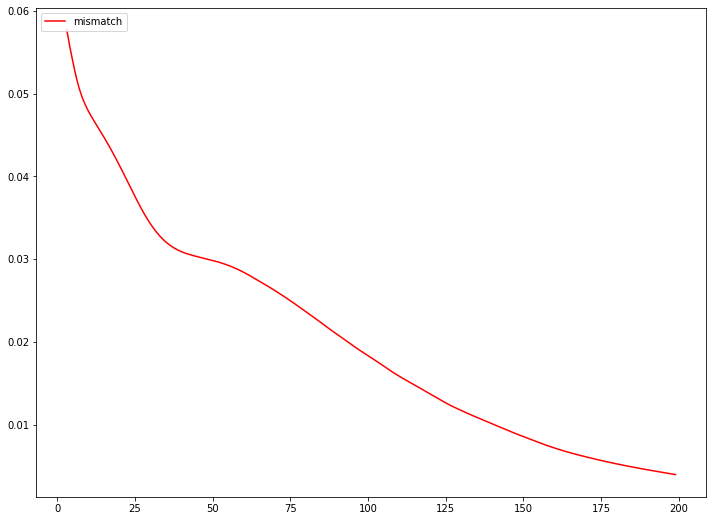

In [198]:
figband = plt.figure(figsize = (12, 9))
x=np.arange(3,201)
plt.plot(x, mmatch,'r',label=r'mismatch')
plt.legend(loc='upper left')
if export_bool:
    figband.savefig(mismatch_plot)

In [ ]:
if export_bool:
    with open(export_file,'w') as file:
        writer = csv.writer(file)
        writer.writerow(['mass','mismatch'])
        writer.writerows(np.array([x,mmatch]).T )